In [1]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install timm
!pip install pandas
!pip install scikit-learn
!pip install pytorch-grad-cam

Looking in indexes: https://download.pytorch.org/whl/cu121


ERROR: Could not find a version that satisfies the requirement pytorch-grad-cam (from versions: none)
ERROR: No matching distribution found for pytorch-grad-cam


In [2]:
import os
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_csv_path = os.path.join(os.getcwd(), 'train.csv')
train_folder_path = os.path.join(os.getcwd(), 'train')
test_csv_path = os.path.join(os.getcwd(), 'test.csv')
test_folder_path = os.path.join(os.getcwd(), 'test')
solution_csv_path = os.path.join(os.getcwd(), 'sample-solution.csv')
print(device)

cuda


In [3]:
print(torch.__version__)

2.4.1+cu121


In [4]:
import random
import torch.optim as optim
import os
from tqdm import tqdm
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2
import timm

c:\Users\86110\anaconda3\envs\CV\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DataLoader

In [5]:
import pandas as pd
# {0:id, 1:shapest, 2:type, 3:total_height, 4: instability_type, 5:cam_angle, 6:stable_height}
df = pd.read_csv(train_csv_path)
df_test = pd.read_csv(test_csv_path)
print(df.iloc[:5, 0])

0     54
1    173
2    245
3    465
4    611
Name: id, dtype: int64


In [6]:
from torch.utils.data import Dataset
import random
from PIL import Image, ImageEnhance
import torchvision.transforms as transforms

class CustomTransform:
    def __call__(self, image):
        # PIL to numpy
        image_np = np.array(image)

        # Guassian blury
        blurred_image = cv2.GaussianBlur(image_np, (5, 5), 0)

        # Canny edge check
        edges = cv2.Canny(blurred_image, 100, 200)

        # convert edge to channel 3
        edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

        # overlay
        overlayed_image = cv2.addWeighted(image_np, 1.1, edges_colored, 0.8, 0)

        # convert back to PIL
        final_image = Image.fromarray(overlayed_image)        
        enhancer = ImageEnhance.Contrast(final_image)
        final_image = enhancer.enhance(1.5)
        
        # convert to tensor
        tensor_image = transforms.ToTensor()(final_image)
        
        return tensor_image
        
# dataset for train
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform or transforms.Compose([
            # CustomTransform(),
            transforms.ToTensor(),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            transforms.RandomHorizontalFlip(),
            transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name = str(self.df.iloc[idx, 0]) # obtain pic id
        image = Image.open(os.path.join(train_folder_path, name) + ".jpg")
        stable_height = self.df.iloc[idx, 6] # obtain stable_height
        instability_type = self.df.iloc[idx, 4] # obtain instability_type
        if self.transform:
            image = self.transform(image)
            
        return image, instability_type, stable_height

# dataset for test
class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform or transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name = str(self.df.iloc[idx, 0]) # obtain pic id
        image = Image.open(os.path.join(test_folder_path, name) + ".jpg")
        if self.transform:
            image = self.transform(image)
            
        return image, name

In [7]:
# split the df according to their instablity type
df_type_0 = df[df['instability_type'] == 0]
df_type_1 = df[df['instability_type'] == 1]
df_type_2 = df[df['instability_type'] == 2]
print(df_type_0.shape, df_type_1.shape, df_type_2.shape)

(1920, 7) (3840, 7) (1920, 7)


In [8]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
# Split dataset into train (90%) and eval (10%) with stratified sampling based on 'label' column
model_train_df,model_eval_df=train_test_split(df, test_size=0.1, stratify=df.iloc[:, 6], random_state=7)
instability_type_train_df, instability_type_eval_df = train_test_split(df, test_size=0.1, stratify=df.iloc[:, 6], random_state=7)
type_0_train_df, type_0_eval_df = train_test_split(df_type_0, test_size=0.1, stratify=df_type_0.iloc[:, 6], random_state=7)
type_1_train_df, type_1_eval_df = train_test_split(df_type_1, test_size=0.1, stratify=df_type_1.iloc[:, 6], random_state=7)
type_2_train_df, type_2_eval_df = train_test_split(df_type_2, test_size=0.1, stratify=df_type_2.iloc[:, 6], random_state=7)

# transform for eval
transforms_eval = transforms.Compose([
            transforms.ToTensor()
        ])

# Create Dataset objects
model_train_dataset =TrainDataset(model_train_df, transforms_eval)
model_eval_dataset=TrainDataset(model_eval_df, transforms_eval)

instability_type_train_dataset = TrainDataset(instability_type_train_df)
instability_type_eval_dataset = TrainDataset(instability_type_eval_df, transforms_eval)
type_0_train_dataset = TrainDataset(type_0_train_df)
type_0_eval_dataset = TrainDataset(type_0_eval_df, transforms_eval)
type_1_train_dataset = TrainDataset(type_1_train_df)
type_1_eval_dataset = TrainDataset(type_1_eval_df, transforms_eval)
type_2_train_dataset = TrainDataset(type_2_train_df)
type_2_eval_dataset = TrainDataset(type_2_eval_df, transforms_eval)
test_dataset = TestDataset(df_test)

# Define DataLoader for train and eval datasets
model_train_loader=DataLoader(model_train_dataset, batch_size=64, shuffle=True)
model_eval_loader=DataLoader(model_eval_dataset, batch_size=64, shuffle=False)
instability_type_train_loader = DataLoader(instability_type_train_dataset, batch_size=64, shuffle=True)
instability_type_eval_loader = DataLoader(instability_type_eval_dataset, batch_size=64, shuffle=False)
type_0_train_loader = DataLoader(type_0_train_dataset, batch_size=32, shuffle=True)
type_0_eval_loader = DataLoader(type_0_eval_dataset, batch_size=32, shuffle=False)
type_1_train_loader = DataLoader(type_1_train_dataset, batch_size=32, shuffle=True)
type_1_eval_loader = DataLoader(type_1_eval_dataset, batch_size=32, shuffle=False)
type_2_train_loader = DataLoader(type_2_train_dataset, batch_size=32, shuffle=True)
type_2_eval_loader = DataLoader(type_2_eval_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

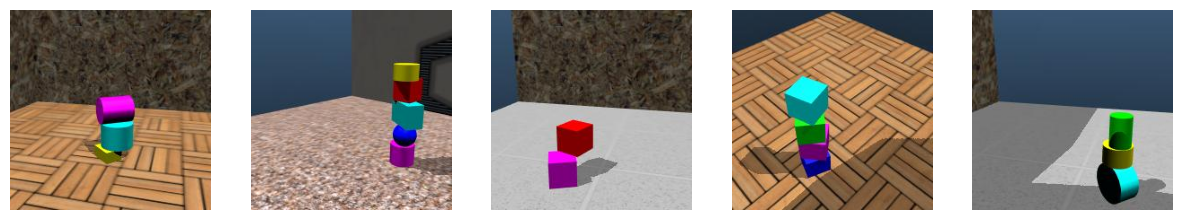

In [8]:
def visualize_transformed_images(dataset, num_images=5):
    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        image_tensor = dataset[i][0] 
        image = image_tensor.permute(1, 2, 0).numpy() 
        image = (image - np.min(image)) / (np.max(image) - np.min(image))
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()
visualize_transformed_images(model_train_dataset)

Model

In [9]:

# This model is used for classify the stable_height （vit）
class vitmodel(nn.Module):
    def __init__(self):
        super(vitmodel, self).__init__()

        self.model = timm.create_model('vit_base_patch32_clip_224.openai_ft_in1k', pretrained=True)

        in_features = self.model.head.in_features  # Obtain model classifier in_features

        self.model.head = nn.Linear(in_features, 6)  # Num_class = 6
        
    def forward(self, x):
        return self.model(x)

In [10]:
# This model is used for classify the stable_height （inception）
class inceptionv4model(nn.Module):
    def __init__(self):
        super(inceptionv4model, self).__init__()
        self.model = timm.create_model('inception_v4.tf_in1k', pretrained=True)
        in_features = self.model.get_classifier().in_features  # Obtain model classifier in_features
        if hasattr(self.model, 'classifier'):
                del self.model.classifier
        self.model.last_linear = nn.Linear(in_features, 6)  # Num_class = 6
        
    def forward(self, x):
        return self.model(x)

In [11]:
# This model is used for classify the stable_height （resnet）
class resnetmodel(nn.Module):
    def __init__(self):
        super(resnetmodel, self).__init__()
        self.model = timm.create_model('resnet50.a1_in1k', pretrained=True)
        in_features = self.model.get_classifier().in_features  # Obtain model classifier in_features
        self.model.fc = nn.Linear(in_features, 6)  # Num_class = 6
        
    def forward(self, x):
        return self.model(x)

In [12]:
# This model is used for classify the stable_height （mobilenet）
class mobilenetmodel(nn.Module):
    def __init__(self):
        super(mobilenetmodel, self).__init__()
        self.model = timm.create_model('mobilenetv3_large_100.ra_in1k', pretrained=True)
        in_features = self.model.classifier.in_features  # Obtain model classifier in_features
        self.model.classifier = nn.Linear(in_features, 6)  # Num_class = 6
        
    def forward(self, x):
        return self.model(x)

In [13]:
# This model is used for classify the instability type
class model1(nn.Module):
    def __init__(self):
        super(model1, self).__init__()
        self.model = timm.create_model('inception_v4.tf_in1k', pretrained=True)
        in_features = self.model.get_classifier().in_features  # Obtain model classifier in_features
        if hasattr(self.model, 'classifier'):
                del self.model.classifier
        self.model.last_linear = nn.Linear(in_features, 3)  # Num_class = 3
        
    def forward(self, x):
        return self.model(x)

In [11]:
# This model is used for classify the stable_height
class model2(nn.Module):
    def __init__(self):
        super(model2, self).__init__()
        self.model = timm.create_model('inception_v4.tf_in1k', pretrained=True)
        in_features = self.model.get_classifier().in_features  # Obtain model classifier in_features
        if hasattr(self.model, 'classifier'):
                del self.model.classifier
        self.model.last_linear = nn.Linear(in_features, 6)  # Num_class = 6
        
    def forward(self, x):
        return self.model(x)

loss function weight allocation

In [14]:
# Obtain distribution of instability_type and stable_height
instability_type = df.iloc[:, 4]
stable_height = df.iloc[:, 6]

instability_type_class_counts = instability_type.value_counts().sort_index()  # Obtain Count of each label
stable_height_class_counts = stable_height.value_counts().sort_index()
total_count = len(instability_type)
instability_type_class_probs = instability_type_class_counts / total_count # Obtain probability of each label
stable_height_class_probs = stable_height_class_counts / total_count

# 1.0 / true prob to make small size labels have higher weight
instability_type_class_weights = 1.0 / instability_type_class_probs
stable_height_class_weights = 1.0 / stable_height_class_probs

instability_type_weights_tensor = torch.tensor(instability_type_class_weights.values, dtype=torch.float).to(device)
stable_height_weights_tensor = torch.tensor(stable_height_class_weights.values, dtype=torch.float).to(device)

# Define CrossEntropyLoss with weight
instability_type_criterion = nn.CrossEntropyLoss(weight=instability_type_weights_tensor)
stable_height_criterion = nn.CrossEntropyLoss(weight=stable_height_weights_tensor)

In [18]:
from sklearn.metrics import f1_score
def instability_type_validate(model):
    model.eval()
    all_predicted = []
    all_labels = []

    with torch.no_grad():  # Without using gradient
        for images, labels, _ in instability_type_eval_loader: # image, instability_type, stable_height
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)  # outputs is [batch_size, 3] shape float type tensor
            probabilities = F.softmax(outputs, dim=1) # Softmax findout probabilites for each label
            predicted_classes = torch.argmax(probabilities, dim=1)  # Find the maximum probability label, output as 1-d tensor

            all_predicted.extend(predicted_classes.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # print(all_predicted)
    # Calculation accuracy and f1-score
    total_correct = sum(np.array(all_predicted) == np.array(all_labels))
    accuracy = total_correct / len(all_labels)
    f1 = f1_score(all_labels, all_predicted, average='weighted')

    print("F-score: %.3f" % f1)
    model.train()
    return accuracy, f1

In [19]:
def stable_height_validate(model, eval_loader):
    model.eval()
    all_predicted = []
    all_labels = []

    with torch.no_grad():  # Without using gradient
        for images,_ , labels in eval_loader: # image, instability_type, stable_height
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)  # outputs is [batch_size, 6] shape float type tensor
            probabilities = F.softmax(outputs, dim=1) # Softmax findout probabilites for each label
            predicted_classes = torch.argmax(probabilities, dim=1)  # Find the maximum probability label, output as 1-d tensor
            predicted_classes = predicted_classes + 1  # Adjust predicted range from [0-5] to [1-6]

            all_predicted.extend(predicted_classes.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # print(all_predicted)
    # Calculation accuracy and f1-score
    total_correct = sum(np.array(all_predicted) == np.array(all_labels))
    accuracy = total_correct / len(all_labels)
    f1 = f1_score(all_labels, all_predicted, average='weighted')

    print("F-score: %.3f" % f1)
    model.train()
    return accuracy, f1

different model training

In [29]:
vit_model = vitmodel()
torch.cuda.empty_cache()
vit_model.to(device)
print(vit_model)

vitmodel(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, b

In [42]:
inception_v4_model= inceptionv4model()
torch.cuda.empty_cache()
inception_v4_model.to(device)
print(inception_v4_model)

inceptionv4model(
  (model): InceptionV4(
    (features): Sequential(
      (0): ConvNormAct(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (1): ConvNormAct(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (2): ConvNormAct(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (3): Mixed3a(
        (maxpool): 

In [26]:
resnet_model= resnetmodel()
torch.cuda.empty_cache()
resnet_model.to(device)
print(resnet_model)

resnetmodel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, mo

In [44]:
mobilenet_model= mobilenetmodel()
torch.cuda.empty_cache()
mobilenet_model.to(device)
print(mobilenet_model)

mobilenetmodel(
  (model): MobileNetV3(
    (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Hardswish()
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (bn1): BatchNormAct2d(
            16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (aa): Identity()
          (se): Identity()
          (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNormAct2d(
            16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Identity()
          )

In [45]:
import random
import torch.optim as optim
import os
from tqdm import tqdm
import numpy as np
from statistics import mean
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
#model training
def modeltraining(model,savepath,log):
    num_epoch = 20

    lr = 0.0005
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

    torch.manual_seed(7)
    torch.cuda.manual_seed_all(7)
    random.seed(7)

    current_dir = os.getcwd()
    save_path = os.path.join(current_dir,savepath) #"best_XXX_model.bin"

    maximum_accuracy = 0
    writer = SummaryWriter(log_dir=log)#'runs/XXX_model'

    for epoch in range(num_epoch):
        avg_loss = 0
        total_correct = 0
        model.train()
        for (i, batch) in enumerate(tqdm(model_train_loader)):
            images, _, labels = batch # image, instability_type, stable_height
            images = images.to(device)
            labels = labels.to(device)
            labels = labels - 1

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)  # outputs is [batch_size, 6] shape float type tensor
            probabilities = F.softmax(outputs, dim=1) # Softmax findout probabilites for each label
            predicted_classes = torch.argmax(probabilities, dim=1)  # Find the maximum probability label, output as 1-d tensor
            loss = stable_height_criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step() # upgrade weight
            avg_loss += loss.item()
            total_correct += (predicted_classes == labels).sum().item()  # Acc correct predict No.
                
        print("epoch: %d, train loss: %.6f, train accuracy: %.6f" % (epoch, avg_loss / df.shape[0], total_correct / df.shape[0]))
        writer.add_scalar("Train Loss", avg_loss / df.shape[0], epoch)
        writer.add_scalar("Train Accuracy", total_correct / df.shape[0], epoch)
        writer.flush()

        val_accuracy, val_fscore = stable_height_validate(model,model_eval_loader)
        print("current accuracy:", val_accuracy, "current f-socre:", val_fscore)
        if val_accuracy > maximum_accuracy:
            maximum_accuracy = val_accuracy
            torch.save(model.state_dict(), save_path)
            print("best accuracy:", maximum_accuracy)

In [32]:
modeltraining(vit_model,"best_vit_model.bin",'runs/vit_model')

  0%|          | 0/108 [00:00<?, ?it/s]

100%|██████████| 108/108 [00:33<00:00,  3.18it/s]


epoch: 0, train loss: 0.025809, train accuracy: 0.131510
F-score: 0.100
current accuracy: 0.25 current f-socre: 0.10000000000000002
best accuracy: 0.25


100%|██████████| 108/108 [00:37<00:00,  2.89it/s]


epoch: 1, train loss: 0.025431, train accuracy: 0.144792
F-score: 0.100
current accuracy: 0.25 current f-socre: 0.10000000000000002


100%|██████████| 108/108 [00:39<00:00,  2.71it/s]


epoch: 2, train loss: 0.025373, train accuracy: 0.150260
F-score: 0.039
current accuracy: 0.14973958333333334 current f-socre: 0.0390035154775387


100%|██████████| 108/108 [00:39<00:00,  2.76it/s]


epoch: 3, train loss: 0.025367, train accuracy: 0.145443
F-score: 0.100
current accuracy: 0.25 current f-socre: 0.10000000000000002


100%|██████████| 108/108 [00:37<00:00,  2.86it/s]


epoch: 4, train loss: 0.025365, train accuracy: 0.150911
F-score: 0.067
current accuracy: 0.20052083333333334 current f-socre: 0.06698526753434564


100%|██████████| 108/108 [00:39<00:00,  2.70it/s]


epoch: 5, train loss: 0.025281, train accuracy: 0.138021
F-score: 0.018
current accuracy: 0.10026041666666667 current f-socre: 0.018272312623274164


100%|██████████| 108/108 [00:43<00:00,  2.48it/s]


epoch: 6, train loss: 0.025278, train accuracy: 0.135547
F-score: 0.039
current accuracy: 0.14973958333333334 current f-socre: 0.0390035154775387


100%|██████████| 108/108 [00:44<00:00,  2.45it/s]


epoch: 7, train loss: 0.025262, train accuracy: 0.174740
F-score: 0.100
current accuracy: 0.25 current f-socre: 0.10000000000000002


100%|██████████| 108/108 [00:42<00:00,  2.52it/s]


epoch: 8, train loss: 0.025272, train accuracy: 0.149219
F-score: 0.005
current accuracy: 0.049479166666666664 current f-socre: 0.004665529363110008


100%|██████████| 108/108 [00:39<00:00,  2.73it/s]


epoch: 9, train loss: 0.025245, train accuracy: 0.166016
F-score: 0.067
current accuracy: 0.20052083333333334 current f-socre: 0.06698526753434564


100%|██████████| 108/108 [00:43<00:00,  2.51it/s]


epoch: 10, train loss: 0.025264, train accuracy: 0.142969
F-score: 0.067
current accuracy: 0.20052083333333334 current f-socre: 0.06698526753434564


100%|██████████| 108/108 [00:44<00:00,  2.44it/s]


epoch: 11, train loss: 0.025231, train accuracy: 0.153776
F-score: 0.039
current accuracy: 0.14973958333333334 current f-socre: 0.0390035154775387


100%|██████████| 108/108 [00:43<00:00,  2.46it/s]


epoch: 12, train loss: 0.025235, train accuracy: 0.164453
F-score: 0.100
current accuracy: 0.25 current f-socre: 0.10000000000000002


100%|██████████| 108/108 [00:43<00:00,  2.48it/s]


epoch: 13, train loss: 0.025224, train accuracy: 0.141797
F-score: 0.039
current accuracy: 0.14973958333333334 current f-socre: 0.0390035154775387


100%|██████████| 108/108 [00:43<00:00,  2.46it/s]


epoch: 14, train loss: 0.025220, train accuracy: 0.197656
F-score: 0.067
current accuracy: 0.20052083333333334 current f-socre: 0.06698526753434564


100%|██████████| 108/108 [00:42<00:00,  2.57it/s]


epoch: 15, train loss: 0.025222, train accuracy: 0.163802
F-score: 0.039
current accuracy: 0.14973958333333334 current f-socre: 0.0390035154775387


100%|██████████| 108/108 [00:39<00:00,  2.75it/s]


epoch: 16, train loss: 0.025216, train accuracy: 0.184375
F-score: 0.067
current accuracy: 0.20052083333333334 current f-socre: 0.06698526753434564


100%|██████████| 108/108 [00:40<00:00,  2.66it/s]


epoch: 17, train loss: 0.025223, train accuracy: 0.187630
F-score: 0.067
current accuracy: 0.20052083333333334 current f-socre: 0.06698526753434564


100%|██████████| 108/108 [00:41<00:00,  2.57it/s]


epoch: 18, train loss: 0.025215, train accuracy: 0.173437
F-score: 0.005
current accuracy: 0.049479166666666664 current f-socre: 0.004665529363110008


100%|██████████| 108/108 [00:43<00:00,  2.46it/s]


epoch: 19, train loss: 0.025230, train accuracy: 0.159896
F-score: 0.100
current accuracy: 0.25 current f-socre: 0.10000000000000002


In [44]:
modeltraining(inception_v4_model,"best_inception_v4__model.bin",'runs/inception_v4_model')

100%|██████████| 108/108 [05:07<00:00,  2.85s/it]


epoch: 0, train loss: 0.022426, train accuracy: 0.251563
F-score: 0.346
current accuracy: 0.3463541666666667 current f-socre: 0.3457109313063214
best accuracy: 0.3463541666666667


100%|██████████| 108/108 [04:57<00:00,  2.75s/it]


epoch: 1, train loss: 0.018119, train accuracy: 0.404036
F-score: 0.465
current accuracy: 0.453125 current f-socre: 0.46456342511261894
best accuracy: 0.453125


100%|██████████| 108/108 [05:00<00:00,  2.78s/it]


epoch: 2, train loss: 0.015900, train accuracy: 0.479297
F-score: 0.517
current accuracy: 0.5130208333333334 current f-socre: 0.5165660565441667
best accuracy: 0.5130208333333334


100%|██████████| 108/108 [04:54<00:00,  2.73s/it]


epoch: 3, train loss: 0.014177, train accuracy: 0.540495
F-score: 0.572
current accuracy: 0.5559895833333334 current f-socre: 0.5715320427064591
best accuracy: 0.5559895833333334


100%|██████████| 108/108 [04:49<00:00,  2.68s/it]


epoch: 4, train loss: 0.012289, train accuracy: 0.597786
F-score: 0.554
current accuracy: 0.5442708333333334 current f-socre: 0.5544340249791841


100%|██████████| 108/108 [04:50<00:00,  2.69s/it]


epoch: 5, train loss: 0.011108, train accuracy: 0.621875
F-score: 0.565
current accuracy: 0.5625 current f-socre: 0.5651328256165361
best accuracy: 0.5625


100%|██████████| 108/108 [04:50<00:00,  2.69s/it]


epoch: 6, train loss: 0.009800, train accuracy: 0.652214
F-score: 0.562
current accuracy: 0.5494791666666666 current f-socre: 0.5622430824362998


100%|██████████| 108/108 [04:49<00:00,  2.68s/it]


epoch: 7, train loss: 0.008179, train accuracy: 0.695312
F-score: 0.569
current accuracy: 0.5494791666666666 current f-socre: 0.5690326351469385


100%|██████████| 108/108 [04:49<00:00,  2.68s/it]


epoch: 8, train loss: 0.007182, train accuracy: 0.725521
F-score: 0.600
current accuracy: 0.5833333333333334 current f-socre: 0.5998762937744523
best accuracy: 0.5833333333333334


100%|██████████| 108/108 [04:48<00:00,  2.67s/it]


epoch: 9, train loss: 0.006000, train accuracy: 0.755990
F-score: 0.591
current accuracy: 0.5859375 current f-socre: 0.5910931164648157
best accuracy: 0.5859375


100%|██████████| 108/108 [04:47<00:00,  2.66s/it]


epoch: 10, train loss: 0.005097, train accuracy: 0.780990
F-score: 0.575
current accuracy: 0.57421875 current f-socre: 0.5753704359884972


100%|██████████| 108/108 [04:47<00:00,  2.66s/it]


epoch: 11, train loss: 0.004164, train accuracy: 0.798958
F-score: 0.604
current accuracy: 0.6015625 current f-socre: 0.6040912415396635
best accuracy: 0.6015625


100%|██████████| 108/108 [04:47<00:00,  2.66s/it]


epoch: 12, train loss: 0.003685, train accuracy: 0.811328
F-score: 0.603
current accuracy: 0.6015625 current f-socre: 0.6032085998848925


100%|██████████| 108/108 [04:47<00:00,  2.66s/it]


epoch: 13, train loss: 0.003347, train accuracy: 0.821615
F-score: 0.602
current accuracy: 0.6015625 current f-socre: 0.6018128000033625


100%|██████████| 108/108 [04:47<00:00,  2.66s/it]


epoch: 14, train loss: 0.002600, train accuracy: 0.839844
F-score: 0.546
current accuracy: 0.5572916666666666 current f-socre: 0.5459218159542669


100%|██████████| 108/108 [04:47<00:00,  2.66s/it]


epoch: 15, train loss: 0.002762, train accuracy: 0.834115
F-score: 0.580
current accuracy: 0.578125 current f-socre: 0.5800368011509087


100%|██████████| 108/108 [04:47<00:00,  2.66s/it]


epoch: 16, train loss: 0.002100, train accuracy: 0.852604
F-score: 0.584
current accuracy: 0.5794270833333334 current f-socre: 0.583658779111781


100%|██████████| 108/108 [04:47<00:00,  2.66s/it]


epoch: 17, train loss: 0.002800, train accuracy: 0.834635
F-score: 0.607
current accuracy: 0.6015625 current f-socre: 0.607464187660122


100%|██████████| 108/108 [04:47<00:00,  2.66s/it]


epoch: 18, train loss: 0.001590, train accuracy: 0.863151
F-score: 0.625
current accuracy: 0.6276041666666666 current f-socre: 0.6254732374898204
best accuracy: 0.6276041666666666


100%|██████████| 108/108 [04:47<00:00,  2.66s/it]


epoch: 19, train loss: 0.001754, train accuracy: 0.861979
F-score: 0.609
current accuracy: 0.6041666666666666 current f-socre: 0.609388836268984


In [28]:
modeltraining(resnet_model,"best_resnet_model.bin",'runs/resnet_model')

100%|██████████| 108/108 [00:34<00:00,  3.12it/s]


epoch: 0, train loss: 0.023213, train accuracy: 0.218490
F-score: 0.325
current accuracy: 0.3567708333333333 current f-socre: 0.3251665313647482
best accuracy: 0.3567708333333333


100%|██████████| 108/108 [00:32<00:00,  3.37it/s]


epoch: 1, train loss: 0.018303, train accuracy: 0.391667
F-score: 0.456
current accuracy: 0.4466145833333333 current f-socre: 0.4564295031007522
best accuracy: 0.4466145833333333


100%|██████████| 108/108 [00:32<00:00,  3.35it/s]


epoch: 2, train loss: 0.014781, train accuracy: 0.487500
F-score: 0.489
current accuracy: 0.48046875 current f-socre: 0.4892950472542918
best accuracy: 0.48046875


100%|██████████| 108/108 [00:33<00:00,  3.21it/s]


epoch: 3, train loss: 0.011187, train accuracy: 0.587370
F-score: 0.490
current accuracy: 0.4791666666666667 current f-socre: 0.4896788728665375


100%|██████████| 108/108 [00:33<00:00,  3.19it/s]


epoch: 4, train loss: 0.007817, train accuracy: 0.681250
F-score: 0.466
current accuracy: 0.4518229166666667 current f-socre: 0.46645197884983963


100%|██████████| 108/108 [00:33<00:00,  3.22it/s]


epoch: 5, train loss: 0.005215, train accuracy: 0.766797
F-score: 0.487
current accuracy: 0.4765625 current f-socre: 0.4869397300448257


100%|██████████| 108/108 [00:34<00:00,  3.12it/s]


epoch: 6, train loss: 0.003087, train accuracy: 0.820573
F-score: 0.496
current accuracy: 0.4908854166666667 current f-socre: 0.495625833389753
best accuracy: 0.4908854166666667


100%|██████████| 108/108 [00:33<00:00,  3.22it/s]


epoch: 7, train loss: 0.002743, train accuracy: 0.830729
F-score: 0.484
current accuracy: 0.4752604166666667 current f-socre: 0.48424750087626883


100%|██████████| 108/108 [00:34<00:00,  3.17it/s]


epoch: 8, train loss: 0.002309, train accuracy: 0.844010
F-score: 0.472
current accuracy: 0.4713541666666667 current f-socre: 0.4723985087480576


100%|██████████| 108/108 [00:34<00:00,  3.12it/s]


epoch: 9, train loss: 0.001455, train accuracy: 0.863151
F-score: 0.503
current accuracy: 0.49609375 current f-socre: 0.5025503535159178
best accuracy: 0.49609375


100%|██████████| 108/108 [00:34<00:00,  3.14it/s]


epoch: 10, train loss: 0.001822, train accuracy: 0.859115
F-score: 0.494
current accuracy: 0.4921875 current f-socre: 0.49404314897265295


100%|██████████| 108/108 [00:34<00:00,  3.17it/s]


epoch: 11, train loss: 0.000954, train accuracy: 0.878255
F-score: 0.508
current accuracy: 0.5078125 current f-socre: 0.5076291763459697
best accuracy: 0.5078125


100%|██████████| 108/108 [00:34<00:00,  3.11it/s]


epoch: 12, train loss: 0.000936, train accuracy: 0.880990
F-score: 0.523
current accuracy: 0.5130208333333334 current f-socre: 0.523266965591297
best accuracy: 0.5130208333333334


100%|██████████| 108/108 [00:34<00:00,  3.12it/s]


epoch: 13, train loss: 0.001284, train accuracy: 0.868620
F-score: 0.514
current accuracy: 0.5078125 current f-socre: 0.5144283738711003


100%|██████████| 108/108 [00:37<00:00,  2.87it/s]


epoch: 14, train loss: 0.000939, train accuracy: 0.878516
F-score: 0.482
current accuracy: 0.4778645833333333 current f-socre: 0.4816741819892725


100%|██████████| 108/108 [00:47<00:00,  2.26it/s]


epoch: 15, train loss: 0.000535, train accuracy: 0.887109
F-score: 0.492
current accuracy: 0.4921875 current f-socre: 0.49174119928679977


100%|██████████| 108/108 [00:49<00:00,  2.20it/s]


epoch: 16, train loss: 0.000895, train accuracy: 0.882422
F-score: 0.459
current accuracy: 0.4466145833333333 current f-socre: 0.4590455524699511


100%|██████████| 108/108 [00:38<00:00,  2.80it/s]


epoch: 17, train loss: 0.000845, train accuracy: 0.881250
F-score: 0.481
current accuracy: 0.4791666666666667 current f-socre: 0.48105501360275343


100%|██████████| 108/108 [00:35<00:00,  3.06it/s]


epoch: 18, train loss: 0.000319, train accuracy: 0.892578
F-score: 0.495
current accuracy: 0.4869791666666667 current f-socre: 0.4950594262122965


100%|██████████| 108/108 [00:35<00:00,  3.06it/s]


epoch: 19, train loss: 0.000201, train accuracy: 0.895573
F-score: 0.507
current accuracy: 0.50390625 current f-socre: 0.5065043221586258


In [46]:
modeltraining(mobilenet_model,"best_mobilenet_model.bin",'runs/mobilenet_model')

100%|██████████| 108/108 [00:14<00:00,  7.23it/s]


epoch: 0, train loss: 0.022304, train accuracy: 0.252604
F-score: 0.393
current accuracy: 0.3880208333333333 current f-socre: 0.39304667420783007
best accuracy: 0.3880208333333333


100%|██████████| 108/108 [00:14<00:00,  7.47it/s]


epoch: 1, train loss: 0.017500, train accuracy: 0.412240
F-score: 0.463
current accuracy: 0.4557291666666667 current f-socre: 0.46285365790239363
best accuracy: 0.4557291666666667


100%|██████████| 108/108 [00:14<00:00,  7.48it/s]


epoch: 2, train loss: 0.014318, train accuracy: 0.509245
F-score: 0.476
current accuracy: 0.46875 current f-socre: 0.47588983512475425
best accuracy: 0.46875


100%|██████████| 108/108 [00:14<00:00,  7.41it/s]


epoch: 3, train loss: 0.011016, train accuracy: 0.601432
F-score: 0.471
current accuracy: 0.4661458333333333 current f-socre: 0.4707259939840837


100%|██████████| 108/108 [00:14<00:00,  7.37it/s]


epoch: 4, train loss: 0.007722, train accuracy: 0.688411
F-score: 0.415
current accuracy: 0.40625 current f-socre: 0.41528373952752684


100%|██████████| 108/108 [00:14<00:00,  7.45it/s]


epoch: 5, train loss: 0.005681, train accuracy: 0.750391
F-score: 0.442
current accuracy: 0.4375 current f-socre: 0.4418397446997881


100%|██████████| 108/108 [00:14<00:00,  7.40it/s]


epoch: 6, train loss: 0.003733, train accuracy: 0.797656
F-score: 0.439
current accuracy: 0.44140625 current f-socre: 0.4393001549185415


100%|██████████| 108/108 [00:14<00:00,  7.37it/s]


epoch: 7, train loss: 0.002662, train accuracy: 0.831771
F-score: 0.467
current accuracy: 0.4635416666666667 current f-socre: 0.4667285637073875


100%|██████████| 108/108 [00:14<00:00,  7.32it/s]


epoch: 8, train loss: 0.002202, train accuracy: 0.846615
F-score: 0.448
current accuracy: 0.4440104166666667 current f-socre: 0.44817060692256505


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]


epoch: 9, train loss: 0.001643, train accuracy: 0.858464
F-score: 0.477
current accuracy: 0.4635416666666667 current f-socre: 0.4768714302183557


100%|██████████| 108/108 [00:14<00:00,  7.36it/s]


epoch: 10, train loss: 0.001861, train accuracy: 0.852734
F-score: 0.476
current accuracy: 0.4778645833333333 current f-socre: 0.4755800223523439
best accuracy: 0.4778645833333333


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]


epoch: 11, train loss: 0.001038, train accuracy: 0.872396
F-score: 0.470
current accuracy: 0.4713541666666667 current f-socre: 0.47004929047166427


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]


epoch: 12, train loss: 0.001021, train accuracy: 0.874740
F-score: 0.480
current accuracy: 0.4765625 current f-socre: 0.47971381209719355


100%|██████████| 108/108 [00:15<00:00,  7.15it/s]


epoch: 13, train loss: 0.001126, train accuracy: 0.873698
F-score: 0.458
current accuracy: 0.453125 current f-socre: 0.4576049032676313


100%|██████████| 108/108 [00:14<00:00,  7.21it/s]


epoch: 14, train loss: 0.000831, train accuracy: 0.881120
F-score: 0.441
current accuracy: 0.4440104166666667 current f-socre: 0.4413383278575129


100%|██████████| 108/108 [00:14<00:00,  7.21it/s]


epoch: 15, train loss: 0.001151, train accuracy: 0.874479
F-score: 0.450
current accuracy: 0.4479166666666667 current f-socre: 0.44993202831419105


100%|██████████| 108/108 [00:15<00:00,  7.11it/s]


epoch: 16, train loss: 0.000737, train accuracy: 0.880990
F-score: 0.474
current accuracy: 0.4713541666666667 current f-socre: 0.47354456689584695


100%|██████████| 108/108 [00:14<00:00,  7.36it/s]


epoch: 17, train loss: 0.000315, train accuracy: 0.892578
F-score: 0.460
current accuracy: 0.4583333333333333 current f-socre: 0.4600678939141907


100%|██████████| 108/108 [00:14<00:00,  7.36it/s]


epoch: 18, train loss: 0.000927, train accuracy: 0.877083
F-score: 0.456
current accuracy: 0.4518229166666667 current f-socre: 0.45587615449849395


100%|██████████| 108/108 [00:14<00:00,  7.20it/s]


epoch: 19, train loss: 0.000849, train accuracy: 0.878776
F-score: 0.475
current accuracy: 0.4713541666666667 current f-socre: 0.4752440727324176


In [47]:
def modelpredict(model, save_path):
    model.load_state_dict(torch.load(save_path))
    model.eval()
    
    all_predicted = []
    all_ids = []

    with torch.no_grad():  # Without using gradient
        for images, ids in test_loader:
            images = images.to(device)
            outputs = model(images)  # outputs is [batch_size, 6] shape float type tensor
            probabilities = F.softmax(outputs, dim=1) # Softmax findout probabilites for each label
            predicted_classes = torch.argmax(probabilities, dim=1)  # Find the maximum probability label, output as 1-d tensor
            predicted_classes = predicted_classes + 1 # Adjust predicted range from [0-5] to [1-6]

            all_predicted.extend(predicted_classes.cpu().numpy())
            all_ids.extend(ids)

    predict_df = pd.DataFrame({
        'id': all_ids,
        'stable_height': all_predicted
    })
    predict_df.to_csv('solution_mobilenet_model.csv', index = False)

In [34]:
modelpredict(vit_model,"best_vit_model.bin")

C:\Users\86110\AppData\Local\Temp\ipykernel_29660\728625203.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


In [48]:
modelpredict(inception_v4_model,"best_inception_v4__model.bin")

C:\Users\86110\AppData\Local\Temp\ipykernel_29660\2615571066.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


In [30]:
modelpredict(resnet_model,"best_resnet_model.bin")

C:\Users\86110\AppData\Local\Temp\ipykernel_26180\378944644.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


In [48]:
modelpredict(mobilenet_model,"best_mobilenet_model.bin")

C:\Users\86110\AppData\Local\Temp\ipykernel_26180\1303007356.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


In [15]:
instability_type_model = model1()
torch.cuda.empty_cache()
instability_type_model.to(device)
print(instability_type_model)

model1(
  (model): InceptionV4(
    (features): Sequential(
      (0): ConvNormAct(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (1): ConvNormAct(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (2): ConvNormAct(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (3): Mixed3a(
        (maxpool): MaxPool2d(

In [40]:
# instability_type_model training
import random
import torch.optim as optim
import os
from tqdm import tqdm
import numpy as np
from statistics import mean
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

num_epoch = 40

lr = 0.0005
optimizer = torch.optim.Adam(instability_type_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

torch.manual_seed(7)
torch.cuda.manual_seed_all(7)
random.seed(7)

current_dir = os.getcwd()
save_path = os.path.join(current_dir, "best_model_instability_type.bin")

maximum_accuracy = 0
writer = SummaryWriter(log_dir='runs/instability_type_model')

for epoch in range(num_epoch):
    avg_loss = 0
    total_correct = 0
    instability_type_model.train()
    for (i, batch) in enumerate(tqdm(instability_type_train_loader)):
        images, labels, _ = batch # image, instability_type, stable_height
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = instability_type_model(images)  # outputs is [batch_size, 3] shape float type tensor
        probabilities = F.softmax(outputs, dim=1) # Softmax findout probabilites for each label
        predicted_classes = torch.argmax(probabilities, dim=1)  # Find the maximum probability label, output as 1-d tensor
        loss = instability_type_criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step() # upgrade weight
        avg_loss += loss.item()
        total_correct += (predicted_classes == labels).sum().item()  # Acc correct predict No.
            
    print("epoch: %d, train loss: %.6f, train accuracy: %.6f" % (epoch, avg_loss / df.shape[0], total_correct / df.shape[0]))
    writer.add_scalar("Train Loss", avg_loss / df.shape[0], epoch)
    writer.add_scalar("Train Accuracy", total_correct / df.shape[0], epoch)
    writer.flush()

    val_accuracy, val_fscore = instability_type_validate(instability_type_model)
    print("current accuracy:", val_accuracy, "current f-socre:", val_fscore)
    if val_accuracy > maximum_accuracy:
        maximum_accuracy = val_accuracy
        torch.save(instability_type_model.state_dict(), save_path)
        print("best accuracy:", maximum_accuracy)
    
    

100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:58<00:00,  1.10s/it]


epoch: 0, train loss: 0.004383, train accuracy: 0.765625
F-score: 0.636
current accuracy: 0.6263020833333334 current f-socre: 0.6364525024890585
best accuracy: 0.6263020833333334


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:57<00:00,  1.09s/it]


epoch: 1, train loss: 0.003948, train accuracy: 0.775781
F-score: 0.727
current accuracy: 0.7135416666666666 current f-socre: 0.7266199143819007
best accuracy: 0.7135416666666666


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:56<00:00,  1.08s/it]


epoch: 2, train loss: 0.003733, train accuracy: 0.790104
F-score: 0.719
current accuracy: 0.7083333333333334 current f-socre: 0.7188690161833343


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:56<00:00,  1.08s/it]


epoch: 3, train loss: 0.003592, train accuracy: 0.787370
F-score: 0.709
current accuracy: 0.6953125 current f-socre: 0.7092644667027166


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:56<00:00,  1.08s/it]


epoch: 4, train loss: 0.003473, train accuracy: 0.793620
F-score: 0.685
current accuracy: 0.6692708333333334 current f-socre: 0.6852700110754734


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:56<00:00,  1.08s/it]


epoch: 5, train loss: 0.003413, train accuracy: 0.796354
F-score: 0.730
current accuracy: 0.7200520833333334 current f-socre: 0.729914294715431
best accuracy: 0.7200520833333334


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:56<00:00,  1.08s/it]


epoch: 6, train loss: 0.003291, train accuracy: 0.802604
F-score: 0.701
current accuracy: 0.6848958333333334 current f-socre: 0.7008575635020464


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:56<00:00,  1.08s/it]


epoch: 7, train loss: 0.003119, train accuracy: 0.804297
F-score: 0.640
current accuracy: 0.62890625 current f-socre: 0.6400293096834838


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:55<00:00,  1.07s/it]


epoch: 8, train loss: 0.003079, train accuracy: 0.803385
F-score: 0.738
current accuracy: 0.7278645833333334 current f-socre: 0.7380232812059736
best accuracy: 0.7278645833333334


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:55<00:00,  1.07s/it]


epoch: 9, train loss: 0.002877, train accuracy: 0.811719
F-score: 0.732
current accuracy: 0.7239583333333334 current f-socre: 0.7317894376323966


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:56<00:00,  1.08s/it]


epoch: 10, train loss: 0.002858, train accuracy: 0.817187
F-score: 0.711
current accuracy: 0.6953125 current f-socre: 0.7114467202000979


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:56<00:00,  1.08s/it]


epoch: 11, train loss: 0.002708, train accuracy: 0.820703
F-score: 0.668
current accuracy: 0.6484375 current f-socre: 0.6683227822934666


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:56<00:00,  1.08s/it]


epoch: 12, train loss: 0.002566, train accuracy: 0.825521
F-score: 0.717
current accuracy: 0.7044270833333334 current f-socre: 0.717296851135432


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:56<00:00,  1.08s/it]


epoch: 13, train loss: 0.002698, train accuracy: 0.818620
F-score: 0.753
current accuracy: 0.7447916666666666 current f-socre: 0.7534212789574001
best accuracy: 0.7447916666666666


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:56<00:00,  1.08s/it]


epoch: 14, train loss: 0.002388, train accuracy: 0.830729
F-score: 0.697
current accuracy: 0.6822916666666666 current f-socre: 0.6970440081902028


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:57<00:00,  1.09s/it]


epoch: 15, train loss: 0.002344, train accuracy: 0.833854
F-score: 0.715
current accuracy: 0.7044270833333334 current f-socre: 0.7147674304501627


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:56<00:00,  1.08s/it]


epoch: 16, train loss: 0.002342, train accuracy: 0.834115
F-score: 0.726
current accuracy: 0.7122395833333334 current f-socre: 0.7257794413170325


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:56<00:00,  1.08s/it]


epoch: 17, train loss: 0.002198, train accuracy: 0.835677
F-score: 0.732
current accuracy: 0.7291666666666666 current f-socre: 0.7322968396452091


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:57<00:00,  1.09s/it]


epoch: 18, train loss: 0.001987, train accuracy: 0.844010
F-score: 0.748
current accuracy: 0.7421875 current f-socre: 0.7482058014950406


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:57<00:00,  1.09s/it]


epoch: 19, train loss: 0.002040, train accuracy: 0.842969
F-score: 0.732
current accuracy: 0.7369791666666666 current f-socre: 0.7319891969860831


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:57<00:00,  1.09s/it]


epoch: 20, train loss: 0.001882, train accuracy: 0.848437
F-score: 0.744
current accuracy: 0.734375 current f-socre: 0.7439536073467389


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:57<00:00,  1.09s/it]


epoch: 21, train loss: 0.001886, train accuracy: 0.847786
F-score: 0.706
current accuracy: 0.6901041666666666 current f-socre: 0.7062349286709408


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:57<00:00,  1.09s/it]


epoch: 22, train loss: 0.001671, train accuracy: 0.854688
F-score: 0.701
current accuracy: 0.6848958333333334 current f-socre: 0.7008143806774818


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:57<00:00,  1.09s/it]


epoch: 23, train loss: 0.001702, train accuracy: 0.851693
F-score: 0.633
current accuracy: 0.6171875 current f-socre: 0.6334772478070175


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:57<00:00,  1.09s/it]


epoch: 24, train loss: 0.001604, train accuracy: 0.856510
F-score: 0.724
current accuracy: 0.7174479166666666 current f-socre: 0.7239491098880354


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:57<00:00,  1.09s/it]


epoch: 25, train loss: 0.001606, train accuracy: 0.856901
F-score: 0.739
current accuracy: 0.7291666666666666 current f-socre: 0.7386227175580226


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:57<00:00,  1.09s/it]


epoch: 26, train loss: 0.001539, train accuracy: 0.857682
F-score: 0.740
current accuracy: 0.7330729166666666 current f-socre: 0.7400524519543658


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:57<00:00,  1.09s/it]


epoch: 27, train loss: 0.001542, train accuracy: 0.858594
F-score: 0.725
current accuracy: 0.7200520833333334 current f-socre: 0.7248043674603881


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:57<00:00,  1.09s/it]


epoch: 28, train loss: 0.001455, train accuracy: 0.861979
F-score: 0.666
current accuracy: 0.6549479166666666 current f-socre: 0.6658636758452943


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:57<00:00,  1.09s/it]


epoch: 29, train loss: 0.001401, train accuracy: 0.862500
F-score: 0.732
current accuracy: 0.7239583333333334 current f-socre: 0.7317260037466768


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:56<00:00,  1.08s/it]


epoch: 30, train loss: 0.001329, train accuracy: 0.865755
F-score: 0.684
current accuracy: 0.6653645833333334 current f-socre: 0.6839586320329151


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:56<00:00,  1.08s/it]


epoch: 31, train loss: 0.001356, train accuracy: 0.864453
F-score: 0.749
current accuracy: 0.7395833333333334 current f-socre: 0.7485929277883069


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:56<00:00,  1.08s/it]


epoch: 32, train loss: 0.001178, train accuracy: 0.865755
F-score: 0.698
current accuracy: 0.6809895833333334 current f-socre: 0.698442146346644


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:56<00:00,  1.08s/it]


epoch: 33, train loss: 0.001207, train accuracy: 0.868620
F-score: 0.715
current accuracy: 0.7005208333333334 current f-socre: 0.7145493089695393


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:56<00:00,  1.07s/it]


epoch: 34, train loss: 0.001156, train accuracy: 0.868880
F-score: 0.743
current accuracy: 0.7317708333333334 current f-socre: 0.7429812346171681


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:56<00:00,  1.08s/it]


epoch: 35, train loss: 0.001414, train accuracy: 0.862109
F-score: 0.690
current accuracy: 0.671875 current f-socre: 0.689867925945656


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:56<00:00,  1.08s/it]


epoch: 36, train loss: 0.001279, train accuracy: 0.865234
F-score: 0.739
current accuracy: 0.7317708333333334 current f-socre: 0.7393588976498804


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:56<00:00,  1.08s/it]


epoch: 37, train loss: 0.001198, train accuracy: 0.868229
F-score: 0.709
current accuracy: 0.6953125 current f-socre: 0.7091935016754496


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:56<00:00,  1.08s/it]


epoch: 38, train loss: 0.001325, train accuracy: 0.866016
F-score: 0.716
current accuracy: 0.7005208333333334 current f-socre: 0.716402664395449


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:56<00:00,  1.08s/it]


epoch: 39, train loss: 0.001327, train accuracy: 0.863542
F-score: 0.715
current accuracy: 0.69921875 current f-socre: 0.7147506599603016


In [17]:
type_0_model = model2()
torch.cuda.empty_cache()
type_0_model.to(device)
print(type_0_model)

model2(
  (model): InceptionV4(
    (features): Sequential(
      (0): ConvNormAct(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (1): ConvNormAct(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (2): ConvNormAct(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (3): Mixed3a(
        (maxpool): MaxPool2d(

In [18]:
#  type 0 instability model training

num_epoch = 40
lr = 0.0005
optimizer = torch.optim.Adam(type_0_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

torch.manual_seed(7)
torch.cuda.manual_seed_all(7)
random.seed(7)

current_dir = os.getcwd()
save_path = os.path.join(current_dir, "best_model_type_0.bin")

maximum_accuracy = 0
writer = SummaryWriter(log_dir='runs/type_0_instability_model')

for epoch in range(num_epoch):
    avg_loss = 0
    total_correct = 0
    type_0_model.train()
    for (i, batch) in enumerate(tqdm(type_0_train_loader)):
        images, _, labels = batch # image, instability_type, stable_height
        images = images.to(device)
        labels = labels.to(device)
        labels = labels - 1

        # Forward pass
        optimizer.zero_grad()
        outputs = type_0_model(images)  # outputs is [batch_size, 6] shape float type tensor
        probabilities = F.softmax(outputs, dim=1) # Softmax findout probabilites for each label
        predicted_classes = torch.argmax(probabilities, dim=1)  # Find the maximum probability label, output as 1-d tensor
        loss = stable_height_criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step() # upgrade weight
        avg_loss += loss.item()
        total_correct += (predicted_classes == labels).sum().item()  # Acc correct predict No.
            
    print("epoch: %d, train loss: %.6f, train accuracy: %.6f" % (epoch, avg_loss / df_type_0.shape[0], total_correct / df_type_0.shape[0]))
    writer.add_scalar("Train Loss", avg_loss / df_type_0.shape[0], epoch)
    writer.add_scalar("Train Accuracy", total_correct / df_type_0.shape[0], epoch)
    writer.flush()

    val_accuracy, val_fscore = stable_height_validate(type_0_model, type_0_eval_loader)
    print("current accuracy:", val_accuracy, "current f-socre:", val_fscore)
    if val_accuracy > maximum_accuracy:
        maximum_accuracy = val_accuracy
        torch.save(type_0_model.state_dict(), save_path)
        print("best accuracy:", maximum_accuracy)

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:20<00:00,  2.58it/s]


epoch: 0, train loss: 0.025984, train accuracy: 0.506250
F-score: 0.546
current accuracy: 0.5520833333333334 current f-socre: 0.5461680405530126
best accuracy: 0.5520833333333334


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:20<00:00,  2.63it/s]


epoch: 1, train loss: 0.017413, train accuracy: 0.654167
F-score: 0.792
current accuracy: 0.796875 current f-socre: 0.7924554959615935
best accuracy: 0.796875


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:20<00:00,  2.63it/s]


epoch: 2, train loss: 0.012985, train accuracy: 0.729167
F-score: 0.570
current accuracy: 0.578125 current f-socre: 0.5704245347564313


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:20<00:00,  2.61it/s]


epoch: 3, train loss: 0.010681, train accuracy: 0.755208
F-score: 0.798
current accuracy: 0.8020833333333334 current f-socre: 0.7980413038138269
best accuracy: 0.8020833333333334


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:20<00:00,  2.64it/s]


epoch: 4, train loss: 0.009106, train accuracy: 0.793750
F-score: 0.858
current accuracy: 0.859375 current f-socre: 0.8580944065410439
best accuracy: 0.859375


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:20<00:00,  2.64it/s]


epoch: 5, train loss: 0.009590, train accuracy: 0.783854
F-score: 0.800
current accuracy: 0.8020833333333334 current f-socre: 0.8003712323078519


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:20<00:00,  2.64it/s]


epoch: 6, train loss: 0.007834, train accuracy: 0.797917
F-score: 0.777
current accuracy: 0.78125 current f-socre: 0.7773342182011268


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:20<00:00,  2.64it/s]


epoch: 7, train loss: 0.008293, train accuracy: 0.802604
F-score: 0.910
current accuracy: 0.9114583333333334 current f-socre: 0.9101955129554837
best accuracy: 0.9114583333333334


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:20<00:00,  2.63it/s]


epoch: 8, train loss: 0.006890, train accuracy: 0.825521
F-score: 0.832
current accuracy: 0.8333333333333334 current f-socre: 0.8320322774548128


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:20<00:00,  2.59it/s]


epoch: 9, train loss: 0.006793, train accuracy: 0.820833
F-score: 0.894
current accuracy: 0.8958333333333334 current f-socre: 0.8939575263104675


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:28<00:00,  1.90it/s]


epoch: 10, train loss: 0.006816, train accuracy: 0.816146
F-score: 0.933
current accuracy: 0.9322916666666666 current f-socre: 0.9326330255106048
best accuracy: 0.9322916666666666


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:30<00:00,  1.79it/s]


epoch: 11, train loss: 0.005352, train accuracy: 0.842187
F-score: 0.925
current accuracy: 0.9270833333333334 current f-socre: 0.9254858560040522


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:30<00:00,  1.79it/s]


epoch: 12, train loss: 0.004512, train accuracy: 0.848958
F-score: 0.890
current accuracy: 0.890625 current f-socre: 0.8899329989314929


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:29<00:00,  1.80it/s]


epoch: 13, train loss: 0.006293, train accuracy: 0.833854
F-score: 0.928
current accuracy: 0.9270833333333334 current f-socre: 0.9275204250444956


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:30<00:00,  1.79it/s]


epoch: 14, train loss: 0.005513, train accuracy: 0.834896
F-score: 0.890
current accuracy: 0.890625 current f-socre: 0.8898562606270147


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:30<00:00,  1.80it/s]


epoch: 15, train loss: 0.004370, train accuracy: 0.853125
F-score: 0.720
current accuracy: 0.7239583333333334 current f-socre: 0.7199348370260799


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:30<00:00,  1.80it/s]


epoch: 16, train loss: 0.006146, train accuracy: 0.832812
F-score: 0.873
current accuracy: 0.875 current f-socre: 0.8734299004111654


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:30<00:00,  1.80it/s]


epoch: 17, train loss: 0.004337, train accuracy: 0.855208
F-score: 0.857
current accuracy: 0.859375 current f-socre: 0.8566925351071691


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:29<00:00,  1.83it/s]


epoch: 18, train loss: 0.005919, train accuracy: 0.840625
F-score: 0.943
current accuracy: 0.9427083333333334 current f-socre: 0.9428103238923454
best accuracy: 0.9427083333333334


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:20<00:00,  2.65it/s]


epoch: 19, train loss: 0.004229, train accuracy: 0.859896
F-score: 0.869
current accuracy: 0.8697916666666666 current f-socre: 0.8691026174104585


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:20<00:00,  2.58it/s]


epoch: 20, train loss: 0.004024, train accuracy: 0.856250
F-score: 0.889
current accuracy: 0.890625 current f-socre: 0.8890268108386046


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:29<00:00,  1.85it/s]


epoch: 21, train loss: 0.003014, train accuracy: 0.862500
F-score: 0.896
current accuracy: 0.8958333333333334 current f-socre: 0.8955132086163253


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:30<00:00,  1.79it/s]


epoch: 22, train loss: 0.004501, train accuracy: 0.850000
F-score: 0.764
current accuracy: 0.765625 current f-socre: 0.7641437201296356


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:30<00:00,  1.79it/s]


epoch: 23, train loss: 0.002987, train accuracy: 0.866667
F-score: 0.871
current accuracy: 0.875 current f-socre: 0.8714108154442458


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:30<00:00,  1.79it/s]


epoch: 24, train loss: 0.004220, train accuracy: 0.855208
F-score: 0.874
current accuracy: 0.875 current f-socre: 0.8739335696919323


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:30<00:00,  1.79it/s]


epoch: 25, train loss: 0.003075, train accuracy: 0.868229
F-score: 0.879
current accuracy: 0.8802083333333334 current f-socre: 0.8793998854827344


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:30<00:00,  1.79it/s]


epoch: 26, train loss: 0.004311, train accuracy: 0.855208
F-score: 0.900
current accuracy: 0.9010416666666666 current f-socre: 0.9002473545868629


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:30<00:00,  1.79it/s]


epoch: 27, train loss: 0.004384, train accuracy: 0.860938
F-score: 0.900
current accuracy: 0.9010416666666666 current f-socre: 0.9004701510706244


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:29<00:00,  1.81it/s]


epoch: 28, train loss: 0.002988, train accuracy: 0.869271
F-score: 0.827
current accuracy: 0.828125 current f-socre: 0.8269498723944966


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:29<00:00,  1.80it/s]


epoch: 29, train loss: 0.003807, train accuracy: 0.862500
F-score: 0.831
current accuracy: 0.8333333333333334 current f-socre: 0.8314507775654048


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:30<00:00,  1.79it/s]


epoch: 30, train loss: 0.002753, train accuracy: 0.875000
F-score: 0.854
current accuracy: 0.8541666666666666 current f-socre: 0.8535044101777358


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:28<00:00,  1.88it/s]


epoch: 31, train loss: 0.002707, train accuracy: 0.872396
F-score: 0.832
current accuracy: 0.8333333333333334 current f-socre: 0.8321359837459522


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:20<00:00,  2.61it/s]


epoch: 32, train loss: 0.002770, train accuracy: 0.870833
F-score: 0.869
current accuracy: 0.8697916666666666 current f-socre: 0.8692209282487059


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:29<00:00,  1.81it/s]


epoch: 33, train loss: 0.002837, train accuracy: 0.873437
F-score: 0.798
current accuracy: 0.8020833333333334 current f-socre: 0.7984165062218213


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:30<00:00,  1.80it/s]


epoch: 34, train loss: 0.003376, train accuracy: 0.864583
F-score: 0.794
current accuracy: 0.796875 current f-socre: 0.7943262909963541


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:29<00:00,  1.81it/s]


epoch: 35, train loss: 0.004749, train accuracy: 0.859896
F-score: 0.853
current accuracy: 0.8541666666666666 current f-socre: 0.8531960063891805


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:29<00:00,  1.82it/s]


epoch: 36, train loss: 0.003432, train accuracy: 0.862500
F-score: 0.847
current accuracy: 0.8489583333333334 current f-socre: 0.8469918259100978


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:29<00:00,  1.81it/s]


epoch: 37, train loss: 0.002622, train accuracy: 0.877604
F-score: 0.793
current accuracy: 0.796875 current f-socre: 0.7928101961250708


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:29<00:00,  1.82it/s]


epoch: 38, train loss: 0.003994, train accuracy: 0.856250
F-score: 0.863
current accuracy: 0.8645833333333334 current f-socre: 0.8634246992145691


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:29<00:00,  1.81it/s]


epoch: 39, train loss: 0.002526, train accuracy: 0.874479
F-score: 0.753
current accuracy: 0.7604166666666666 current f-socre: 0.7527779395578423


In [35]:
type_1_model = model2()
torch.cuda.empty_cache()
type_1_model.to(device)
print(type_1_model)

model2(
  (model): InceptionV4(
    (features): Sequential(
      (0): ConvNormAct(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (1): ConvNormAct(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (2): ConvNormAct(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (3): Mixed3a(
        (maxpool): MaxPool2d(

In [36]:
#  type 1 instability model training

num_epoch = 40
lr = 0.0003
optimizer = torch.optim.Adam(type_1_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

torch.manual_seed(7)
torch.cuda.manual_seed_all(7)
random.seed(7)

current_dir = os.getcwd()
save_path = os.path.join(current_dir, "best_model_type_1.bin")

maximum_accuracy = 0
writer = SummaryWriter(log_dir='runs/type_1_instability_model')

for epoch in range(num_epoch):
    avg_loss = 0
    total_correct = 0
    type_1_model.train()
    for (i, batch) in enumerate(tqdm(type_1_train_loader)):
        images, _, labels = batch # image, instability_type, stable_height
        images = images.to(device)
        labels = labels.to(device)
        labels = labels - 1

        # Forward pass
        optimizer.zero_grad()
        outputs = type_1_model(images)  # outputs is [batch_size, 6] shape float type tensor
        probabilities = F.softmax(outputs, dim=1) # Softmax findout probabilites for each label
        predicted_classes = torch.argmax(probabilities, dim=1)  # Find the maximum probability label, output as 1-d tensor
        loss = stable_height_criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step() # upgrade weight
        avg_loss += loss.item()
        total_correct += (predicted_classes == labels).sum().item()  # Acc correct predict No.
            
    print("epoch: %d, train loss: %.6f, train accuracy: %.6f" % (epoch, avg_loss / df_type_1.shape[0], total_correct / df_type_1.shape[0]))
    writer.add_scalar("Train Loss", avg_loss / df_type_1.shape[0], epoch)
    writer.add_scalar("Train Accuracy", total_correct / df_type_1.shape[0], epoch)
    writer.flush()

    val_accuracy, val_fscore = stable_height_validate(type_1_model, type_1_eval_loader)
    print("current accuracy:", val_accuracy, "current f-socre:", val_fscore)
    if val_accuracy > maximum_accuracy:
        maximum_accuracy = val_accuracy
        torch.save(type_1_model.state_dict(), save_path)
        print("best accuracy:", maximum_accuracy)

100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:00<00:00,  1.79it/s]


epoch: 0, train loss: 0.042632, train accuracy: 0.280729
F-score: 0.300
current accuracy: 0.3541666666666667 current f-socre: 0.2997922703420478
best accuracy: 0.3541666666666667


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:00<00:00,  1.80it/s]


epoch: 1, train loss: 0.038019, train accuracy: 0.358854
F-score: 0.388
current accuracy: 0.3984375 current f-socre: 0.3881707802001036
best accuracy: 0.3984375


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:00<00:00,  1.80it/s]


epoch: 2, train loss: 0.034520, train accuracy: 0.432552
F-score: 0.473
current accuracy: 0.4713541666666667 current f-socre: 0.4732440458657922
best accuracy: 0.4713541666666667


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:00<00:00,  1.80it/s]


epoch: 3, train loss: 0.031499, train accuracy: 0.492188
F-score: 0.518
current accuracy: 0.5286458333333334 current f-socre: 0.5183260238694326
best accuracy: 0.5286458333333334


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.80it/s]


epoch: 4, train loss: 0.029367, train accuracy: 0.521354
F-score: 0.522
current accuracy: 0.5286458333333334 current f-socre: 0.52201542102347


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.80it/s]


epoch: 5, train loss: 0.027673, train accuracy: 0.558854
F-score: 0.559
current accuracy: 0.5572916666666666 current f-socre: 0.5592551118536044
best accuracy: 0.5572916666666666


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.81it/s]


epoch: 6, train loss: 0.025632, train accuracy: 0.580469
F-score: 0.560
current accuracy: 0.5651041666666666 current f-socre: 0.5603153126422701
best accuracy: 0.5651041666666666


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:00<00:00,  1.79it/s]


epoch: 7, train loss: 0.024828, train accuracy: 0.597656
F-score: 0.542
current accuracy: 0.5390625 current f-socre: 0.5419872496196108


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.81it/s]


epoch: 8, train loss: 0.022254, train accuracy: 0.627604
F-score: 0.581
current accuracy: 0.5833333333333334 current f-socre: 0.5812070013824783
best accuracy: 0.5833333333333334


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.81it/s]


epoch: 9, train loss: 0.021700, train accuracy: 0.620833
F-score: 0.534
current accuracy: 0.5416666666666666 current f-socre: 0.5340554146799481


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.81it/s]


epoch: 10, train loss: 0.020837, train accuracy: 0.638021
F-score: 0.555
current accuracy: 0.5572916666666666 current f-socre: 0.5547873224829628


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.81it/s]


epoch: 11, train loss: 0.019486, train accuracy: 0.668490
F-score: 0.559
current accuracy: 0.5651041666666666 current f-socre: 0.5591179722171382


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.81it/s]


epoch: 12, train loss: 0.018841, train accuracy: 0.679948
F-score: 0.574
current accuracy: 0.5651041666666666 current f-socre: 0.5736657600581537


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.81it/s]


epoch: 13, train loss: 0.017419, train accuracy: 0.691667
F-score: 0.610
current accuracy: 0.6067708333333334 current f-socre: 0.6097196705762081
best accuracy: 0.6067708333333334


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.81it/s]


epoch: 14, train loss: 0.016087, train accuracy: 0.711719
F-score: 0.596
current accuracy: 0.5989583333333334 current f-socre: 0.5962166638036178


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.81it/s]


epoch: 15, train loss: 0.015832, train accuracy: 0.714583
F-score: 0.584
current accuracy: 0.5651041666666666 current f-socre: 0.5841428127267075


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.81it/s]


epoch: 16, train loss: 0.014337, train accuracy: 0.728646
F-score: 0.592
current accuracy: 0.5885416666666666 current f-socre: 0.5919221447707671


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.81it/s]


epoch: 17, train loss: 0.013564, train accuracy: 0.746615
F-score: 0.583
current accuracy: 0.5859375 current f-socre: 0.5829603618131601


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.81it/s]


epoch: 18, train loss: 0.012514, train accuracy: 0.755990
F-score: 0.510
current accuracy: 0.5208333333333334 current f-socre: 0.5104106132753164


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.81it/s]


epoch: 19, train loss: 0.012480, train accuracy: 0.756250
F-score: 0.566
current accuracy: 0.5677083333333334 current f-socre: 0.5656024427381774


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.82it/s]


epoch: 20, train loss: 0.011266, train accuracy: 0.771094
F-score: 0.563
current accuracy: 0.5729166666666666 current f-socre: 0.5632504914673243


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.81it/s]


epoch: 21, train loss: 0.009726, train accuracy: 0.791406
F-score: 0.576
current accuracy: 0.578125 current f-socre: 0.5763792966210721


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.81it/s]


epoch: 22, train loss: 0.009848, train accuracy: 0.784375
F-score: 0.558
current accuracy: 0.5625 current f-socre: 0.5577060776115499


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.81it/s]


epoch: 23, train loss: 0.008326, train accuracy: 0.804688
F-score: 0.565
current accuracy: 0.5572916666666666 current f-socre: 0.5649318777951896


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.81it/s]


epoch: 24, train loss: 0.008937, train accuracy: 0.803125
F-score: 0.533
current accuracy: 0.5416666666666666 current f-socre: 0.5328732269621886


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.81it/s]


epoch: 25, train loss: 0.009427, train accuracy: 0.795573
F-score: 0.561
current accuracy: 0.5677083333333334 current f-socre: 0.5614215871109377


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.82it/s]


epoch: 26, train loss: 0.007600, train accuracy: 0.816406
F-score: 0.586
current accuracy: 0.5911458333333334 current f-socre: 0.5862751878201178


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.80it/s]


epoch: 27, train loss: 0.006358, train accuracy: 0.827604
F-score: 0.550
current accuracy: 0.5520833333333334 current f-socre: 0.5498850394960408


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.82it/s]


epoch: 28, train loss: 0.007414, train accuracy: 0.819271
F-score: 0.588
current accuracy: 0.5885416666666666 current f-socre: 0.5880955030019218


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.81it/s]


epoch: 29, train loss: 0.007268, train accuracy: 0.820312
F-score: 0.601
current accuracy: 0.5963541666666666 current f-socre: 0.6011150996998921


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.81it/s]


epoch: 30, train loss: 0.006390, train accuracy: 0.832292
F-score: 0.574
current accuracy: 0.5729166666666666 current f-socre: 0.5740563814864141


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.81it/s]


epoch: 31, train loss: 0.005630, train accuracy: 0.840885
F-score: 0.554
current accuracy: 0.5598958333333334 current f-socre: 0.5541723746354449


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.81it/s]


epoch: 32, train loss: 0.005486, train accuracy: 0.836979
F-score: 0.568
current accuracy: 0.5755208333333334 current f-socre: 0.5677018333268333


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.81it/s]


epoch: 33, train loss: 0.004557, train accuracy: 0.845573
F-score: 0.612
current accuracy: 0.6145833333333334 current f-socre: 0.6120915605081984
best accuracy: 0.6145833333333334


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.81it/s]


epoch: 34, train loss: 0.004734, train accuracy: 0.847396
F-score: 0.595
current accuracy: 0.59375 current f-socre: 0.5954297701311383


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.81it/s]


epoch: 35, train loss: 0.004686, train accuracy: 0.845052
F-score: 0.593
current accuracy: 0.5911458333333334 current f-socre: 0.5930273621915508


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.82it/s]


epoch: 36, train loss: 0.004825, train accuracy: 0.847135
F-score: 0.605
current accuracy: 0.6067708333333334 current f-socre: 0.6045479193661073


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.81it/s]


epoch: 37, train loss: 0.004474, train accuracy: 0.854167
F-score: 0.573
current accuracy: 0.5729166666666666 current f-socre: 0.5728823998695741


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.81it/s]


epoch: 38, train loss: 0.005211, train accuracy: 0.846094
F-score: 0.595
current accuracy: 0.5989583333333334 current f-socre: 0.5953744445049888


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:59<00:00,  1.81it/s]


epoch: 39, train loss: 0.004334, train accuracy: 0.848177
F-score: 0.627
current accuracy: 0.6276041666666666 current f-socre: 0.627322924890846
best accuracy: 0.6276041666666666


In [21]:
type_2_model = model2()
torch.cuda.empty_cache()
type_2_model.to(device)
print(type_2_model)

model2(
  (model): InceptionV4(
    (features): Sequential(
      (0): ConvNormAct(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (1): ConvNormAct(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (2): ConvNormAct(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (3): Mixed3a(
        (maxpool): MaxPool2d(

In [22]:
#  type 2 instability model training

num_epoch = 40
lr = 0.0005
optimizer = torch.optim.Adam(type_2_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

torch.manual_seed(7)
torch.cuda.manual_seed_all(7)
random.seed(7)

current_dir = os.getcwd()
save_path = os.path.join(current_dir, "best_model_type_2.bin")

maximum_accuracy = 0
writer = SummaryWriter(log_dir='runs/type_2_instability_model')

for epoch in range(num_epoch):
    avg_loss = 0
    total_correct = 0
    type_2_model.train()
    for (i, batch) in enumerate(tqdm(type_2_train_loader)):
        images, _, labels = batch # image, instability_type, stable_height
        images = images.to(device)
        labels = labels.to(device)
        labels = labels - 1

        # Forward pass
        optimizer.zero_grad()
        outputs = type_2_model(images)  # outputs is [batch_size, 6] shape float type tensor
        probabilities = F.softmax(outputs, dim=1) # Softmax findout probabilites for each label
        predicted_classes = torch.argmax(probabilities, dim=1)  # Find the maximum probability label, output as 1-d tensor
        loss = stable_height_criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step() # upgrade weight
        avg_loss += loss.item()
        total_correct += (predicted_classes == labels).sum().item()  # Acc correct predict No.
            
    print("epoch: %d, train loss: %.6f, train accuracy: %.6f" % (epoch, avg_loss / df_type_2.shape[0], total_correct / df_type_2.shape[0]))
    writer.add_scalar("Train Loss", avg_loss / df_type_2.shape[0], epoch)
    writer.add_scalar("Train Accuracy", total_correct / df_type_2.shape[0], epoch)
    writer.flush()

    val_accuracy, val_fscore = stable_height_validate(type_2_model, type_2_eval_loader)
    print("current accuracy:", val_accuracy, "current f-socre:", val_fscore)
    if val_accuracy > maximum_accuracy:
        maximum_accuracy = val_accuracy
        torch.save(type_2_model.state_dict(), save_path)
        print("best accuracy:", maximum_accuracy)

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:23<00:00,  2.34it/s]


epoch: 0, train loss: 0.036618, train accuracy: 0.432292
F-score: 0.648
current accuracy: 0.65625 current f-socre: 0.6479675377134474
best accuracy: 0.65625


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:23<00:00,  2.34it/s]


epoch: 1, train loss: 0.019487, train accuracy: 0.669271
F-score: 0.457
current accuracy: 0.4791666666666667 current f-socre: 0.4570986183941639


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:23<00:00,  2.34it/s]


epoch: 2, train loss: 0.013913, train accuracy: 0.757812
F-score: 0.775
current accuracy: 0.7916666666666666 current f-socre: 0.775404891675146
best accuracy: 0.7916666666666666


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:23<00:00,  2.33it/s]


epoch: 3, train loss: 0.011109, train accuracy: 0.780729
F-score: 0.797
current accuracy: 0.8072916666666666 current f-socre: 0.7974193654367432
best accuracy: 0.8072916666666666


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:23<00:00,  2.34it/s]


epoch: 4, train loss: 0.008449, train accuracy: 0.820312
F-score: 0.828
current accuracy: 0.8489583333333334 current f-socre: 0.8280053191489362
best accuracy: 0.8489583333333334


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:22<00:00,  2.36it/s]


epoch: 5, train loss: 0.009151, train accuracy: 0.816146
F-score: 0.739
current accuracy: 0.7604166666666666 current f-socre: 0.7391176964444259


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:23<00:00,  2.32it/s]


epoch: 6, train loss: 0.009050, train accuracy: 0.817708
F-score: 0.838
current accuracy: 0.84375 current f-socre: 0.8381902354494013


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:23<00:00,  2.34it/s]


epoch: 7, train loss: 0.006582, train accuracy: 0.836458
F-score: 0.858
current accuracy: 0.8645833333333334 current f-socre: 0.8583824388113603
best accuracy: 0.8645833333333334


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:23<00:00,  2.35it/s]


epoch: 8, train loss: 0.007070, train accuracy: 0.840104
F-score: 0.771
current accuracy: 0.78125 current f-socre: 0.7708098618448881


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:23<00:00,  2.34it/s]


epoch: 9, train loss: 0.006036, train accuracy: 0.845313
F-score: 0.751
current accuracy: 0.7447916666666666 current f-socre: 0.7506567980153313


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:23<00:00,  2.33it/s]


epoch: 10, train loss: 0.008235, train accuracy: 0.825521
F-score: 0.846
current accuracy: 0.8489583333333334 current f-socre: 0.8461093572356667


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:22<00:00,  2.37it/s]


epoch: 11, train loss: 0.004922, train accuracy: 0.849479
F-score: 0.789
current accuracy: 0.8020833333333334 current f-socre: 0.7889393505918386


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:22<00:00,  2.35it/s]


epoch: 12, train loss: 0.005244, train accuracy: 0.850000
F-score: 0.833
current accuracy: 0.8385416666666666 current f-socre: 0.8329963578349434


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:22<00:00,  2.37it/s]


epoch: 13, train loss: 0.005026, train accuracy: 0.850000
F-score: 0.794
current accuracy: 0.7864583333333334 current f-socre: 0.7938668509387918


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:23<00:00,  2.35it/s]


epoch: 14, train loss: 0.005633, train accuracy: 0.847917
F-score: 0.845
current accuracy: 0.8489583333333334 current f-socre: 0.8454975224674417


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:23<00:00,  2.35it/s]


epoch: 15, train loss: 0.003691, train accuracy: 0.864583
F-score: 0.824
current accuracy: 0.8333333333333334 current f-socre: 0.8244635668276974


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:22<00:00,  2.36it/s]


epoch: 16, train loss: 0.003204, train accuracy: 0.871875
F-score: 0.878
current accuracy: 0.8802083333333334 current f-socre: 0.8776281599867257
best accuracy: 0.8802083333333334


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:23<00:00,  2.33it/s]


epoch: 17, train loss: 0.003106, train accuracy: 0.872396
F-score: 0.822
current accuracy: 0.8333333333333334 current f-socre: 0.8221776872552996


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:22<00:00,  2.35it/s]


epoch: 18, train loss: 0.004148, train accuracy: 0.859375
F-score: 0.875
current accuracy: 0.8802083333333334 current f-socre: 0.875282867058504


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:23<00:00,  2.34it/s]


epoch: 19, train loss: 0.003369, train accuracy: 0.872396
F-score: 0.831
current accuracy: 0.8541666666666666 current f-socre: 0.8313429972317103


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:22<00:00,  2.39it/s]


epoch: 20, train loss: 0.002984, train accuracy: 0.869792
F-score: 0.870
current accuracy: 0.8697916666666666 current f-socre: 0.870229242711161


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:22<00:00,  2.36it/s]


epoch: 21, train loss: 0.003068, train accuracy: 0.868750
F-score: 0.849
current accuracy: 0.859375 current f-socre: 0.84928664191291


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:22<00:00,  2.38it/s]


epoch: 22, train loss: 0.003324, train accuracy: 0.865625
F-score: 0.829
current accuracy: 0.8489583333333334 current f-socre: 0.8292647969403385


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:20<00:00,  2.59it/s]


epoch: 23, train loss: 0.003455, train accuracy: 0.870833
F-score: 0.840
current accuracy: 0.8541666666666666 current f-socre: 0.8402265644053224


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:21<00:00,  2.57it/s]


epoch: 24, train loss: 0.003117, train accuracy: 0.871354
F-score: 0.874
current accuracy: 0.8854166666666666 current f-socre: 0.8737651208150853
best accuracy: 0.8854166666666666


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:20<00:00,  2.58it/s]


epoch: 25, train loss: 0.002035, train accuracy: 0.878646
F-score: 0.919
current accuracy: 0.921875 current f-socre: 0.9191000431044333
best accuracy: 0.921875


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:20<00:00,  2.58it/s]


epoch: 26, train loss: 0.001839, train accuracy: 0.881250
F-score: 0.903
current accuracy: 0.90625 current f-socre: 0.9027735289096762


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:20<00:00,  2.63it/s]


epoch: 27, train loss: 0.003085, train accuracy: 0.873958
F-score: 0.856
current accuracy: 0.8541666666666666 current f-socre: 0.8556454876501677


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:20<00:00,  2.60it/s]


epoch: 28, train loss: 0.002733, train accuracy: 0.875521
F-score: 0.874
current accuracy: 0.8802083333333334 current f-socre: 0.8741885315486063


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:20<00:00,  2.61it/s]


epoch: 29, train loss: 0.003772, train accuracy: 0.868750
F-score: 0.893
current accuracy: 0.8958333333333334 current f-socre: 0.8926461362062997


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:20<00:00,  2.58it/s]


epoch: 30, train loss: 0.004060, train accuracy: 0.865625
F-score: 0.846
current accuracy: 0.8489583333333334 current f-socre: 0.8461989559731472


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:20<00:00,  2.60it/s]


epoch: 31, train loss: 0.002881, train accuracy: 0.873958
F-score: 0.832
current accuracy: 0.84375 current f-socre: 0.832075216408529


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:20<00:00,  2.58it/s]


epoch: 32, train loss: 0.002976, train accuracy: 0.870313
F-score: 0.820
current accuracy: 0.8333333333333334 current f-socre: 0.8200725669776481


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:21<00:00,  2.54it/s]


epoch: 33, train loss: 0.002847, train accuracy: 0.876563
F-score: 0.865
current accuracy: 0.8697916666666666 current f-socre: 0.8649966198738915


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:21<00:00,  2.54it/s]


epoch: 34, train loss: 0.002122, train accuracy: 0.878125
F-score: 0.742
current accuracy: 0.7552083333333334 current f-socre: 0.7422787858293293


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:20<00:00,  2.58it/s]


epoch: 35, train loss: 0.001470, train accuracy: 0.885938
F-score: 0.871
current accuracy: 0.875 current f-socre: 0.8713097152871135


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:20<00:00,  2.63it/s]


epoch: 36, train loss: 0.001447, train accuracy: 0.886979
F-score: 0.826
current accuracy: 0.8333333333333334 current f-socre: 0.8257887188382651


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:20<00:00,  2.65it/s]


epoch: 37, train loss: 0.001872, train accuracy: 0.883854
F-score: 0.705
current accuracy: 0.7395833333333334 current f-socre: 0.7045473057644109


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:20<00:00,  2.66it/s]


epoch: 38, train loss: 0.004779, train accuracy: 0.854167
F-score: 0.841
current accuracy: 0.84375 current f-socre: 0.8408049137078742


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:20<00:00,  2.62it/s]


epoch: 39, train loss: 0.003296, train accuracy: 0.869271
F-score: 0.840
current accuracy: 0.84375 current f-socre: 0.8397143421875882


Predict

In [41]:
# This predict the instability type for each test image
def predict(model, save_path):
    model.load_state_dict(torch.load(save_path))
    model.eval()
    
    all_predicted = []
    all_ids = []

    with torch.no_grad():  # Without using gradient
        for images, ids in test_loader:
            images = images.to(device)
            outputs = model(images)  # outputs is [batch_size, 3] shape float type tensor
            probabilities = F.softmax(outputs, dim=1) # Softmax findout probabilites for each label
            predicted_classes = torch.argmax(probabilities, dim=1)  # Find the maximum probability label, output as 1-d tensor

            all_predicted.extend(predicted_classes.cpu().numpy())
            all_ids.extend(ids)

    predict_df = pd.DataFrame({
        'id': all_ids,
        'instability_type': all_predicted
    })

    return predict_df
    
predict_df = predict(instability_type_model, "best_model_instability_type.bin")

C:\Users\Bough\AppData\Local\Temp\ipykernel_37140\3356501654.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


In [42]:
test_df_type_0 = predict_df[predict_df['instability_type'] == 0]
test_df_type_1 = predict_df[predict_df['instability_type'] == 1]
test_df_type_2 = predict_df[predict_df['instability_type'] == 2]
print(test_df_type_0.shape, test_df_type_1.shape, test_df_type_2.shape)

(634, 2) (857, 2) (429, 2)


In [43]:
# This predict the stable height for each type
def predict(model, save_path, loader):
    model.load_state_dict(torch.load(save_path))
    model.eval()
    
    all_predicted = []
    all_ids = []

    with torch.no_grad():  # Without using gradient
        for images, ids in loader:
            images = images.to(device)
            outputs = model(images)  # outputs is [batch_size, 6] shape float type tensor
            probabilities = F.softmax(outputs, dim=1) # Softmax findout probabilites for each label
            predicted_classes = torch.argmax(probabilities, dim=1)  # Find the maximum probability label, output as 1-d tensor
            predicted_classes = predicted_classes + 1 # Adjust predicted range from [0-5] to [1-6]

            all_predicted.extend(predicted_classes.cpu().numpy())
            all_ids.extend(ids)

    predict_df = pd.DataFrame({
        'id': all_ids,
        'stable_height': all_predicted
    })
    return predict_df
    
type_0_test_dataset = TestDataset(test_df_type_0)
type_0_test_loader = DataLoader(type_0_test_dataset, batch_size=64, shuffle=False)
type_1_test_dataset = TestDataset(test_df_type_1)
type_1_test_loader = DataLoader(type_1_test_dataset, batch_size=64, shuffle=False) 
type_2_test_dataset = TestDataset(test_df_type_2)
type_2_test_loader = DataLoader(type_2_test_dataset, batch_size=64, shuffle=False) 
df0 = predict(type_0_model, "best_model_type_0.bin", type_0_test_loader)
df1 = predict(type_1_model, "best_model_type_1.bin", type_1_test_loader)
df2 = predict(type_2_model, "best_model_type_2.bin", type_2_test_loader)

C:\Users\Bough\AppData\Local\Temp\ipykernel_37140\444132097.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


In [44]:
merged_df = pd.concat([df0, df1, df2], axis=0)
df_test['id'] = df_test['id'].astype(int)
merged_df['id'] = merged_df['id'].astype(int)

In [45]:
sorted_df = pd.merge(df_test[['id']], merged_df, on='id', how='left')
sorted_df.to_csv('solution.csv', index=False)

In [1]:
%load_ext tensorboard 
%tensorboard --logdir=runs

SyntaxError: cannot assign to operator (3224537314.py, line 1)